In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

In [2]:
Training_data = pd.read_json("../input/whatscooking/train.json")
Training_data['str_ingredients'] = Training_data.ingredients.apply(lambda x: ','.join(y for y in x))

In [3]:
def describe_dataset(dataset, dataset_name="given"):
    display(dataset.describe())
    cuisines = dataset.groupby("cuisine").count().sort("id", ascending=False)
    display(cuisines.head())
    i = range(cuisines.count().ingredients)
    plt.bar(i, cuisines.ingredients, label='Number of recipes in {} dataset'.format(dataset_name))
    plt.ylabel('total number of recipes')
    plt.title('Number of recipes by type of cuisine')
    plt.xticks(i, cuisines.index.values, rotation='vertical')
    plt.legend(loc='upper right')
    plt.show()

,id
count,39774.000000
mean,24849.536959
std,14360.035505
min,0.000000
25%,12398.250000
50%,24887.000000
75%,37328.500000
max,49717.000000


,id,ingredients,str_ingredients
cuisine,,,
italian,7838,7838,7838
mexican,6438,6438,6438
southern_us,4320,4320,4320
indian,3003,3003,3003
chinese,2673,2673,2673


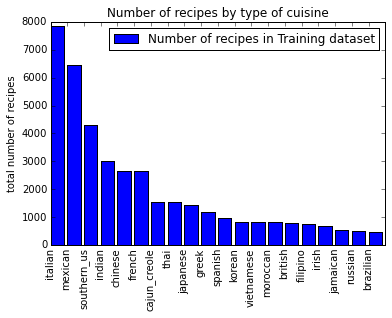

In [4]:
describe_dataset(Training_data, "Training");

In [5]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(Training_data, test_size = 0.2)

,id
count,31819.000000
mean,24827.781577
std,14329.716832
min,0.000000
25%,12455.500000
50%,24829.000000
75%,37262.000000
max,49717.000000


,id,ingredients,str_ingredients
cuisine,,,
italian,6281,6281,6281
mexican,5114,5114,5114
southern_us,3457,3457,3457
indian,2398,2398,2398
chinese,2169,2169,2169


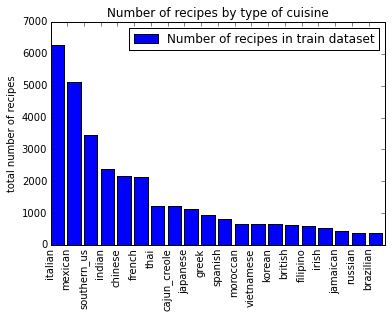

,id
count,7955.000000
mean,24936.555751
std,14481.251263
min,6.000000
25%,12126.000000
50%,25163.000000
75%,37508.500000
max,49707.000000


,id,ingredients,str_ingredients
cuisine,,,
italian,1557,1557,1557
mexican,1324,1324,1324
southern_us,863,863,863
indian,605,605,605
french,520,520,520


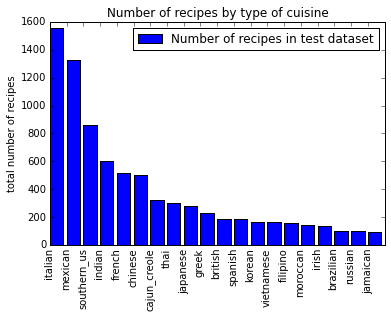

In [6]:
describe_dataset(train, "train");
describe_dataset(test, "test");

In [7]:
import itertools
grouped_ingredients = itertools.groupby(sorted(list(itertools.chain.from_iterable(Training_data.ingredients))))
ingredient_counts = {key:len(list(group)) for key, group in grouped_ingredients}
global_pantry = pd.DataFrame.from_dict(ingredient_counts, orient='index')
global_pantry.columns = ['num_recipes']
display(global_pantry.count())
global_pantry.head()

num_recipes    6714
dtype: int64

,num_recipes
low-sodium fat-free chicken broth,22
sweetened coconut,3
baking chocolate,3
egg roll wrappers,57
bottled low sodium salsa,1


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, vocabulary=global_pantry.index.values)
X_train = vectorizer.fit_transform(train.str_ingredients)
feature_names = vectorizer.get_feature_names()
feature_names = np.asarray(feature_names);

In [9]:
X_test = vectorizer.transform(test.str_ingredients)
y_train = train.cuisine
y_test = test.cuisine

In [10]:
'''
# Should use a chi2 test to see which features are the most useful predictors?
from sklearn.feature_selection import SelectKBest, chi2
def chi2_select_k_best()
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()
''';

In [11]:
from sklearn.utils.extmath import density
from sklearn import metrics
from time import time

def benchmark(name, classifier, verbose=False):
    print "Training: {}".format(classifier)
    
    t0 = time()
    classifier.fit(X_train, y_train)
    train_time = time() - t0
    
    t0 = time()
    predictions = classifier.predict(X_test)
    test_time = time() - t0
    
    score = metrics.accuracy_score(y_test, predictions)
    print "Accuracy: {}".format(score)
    
    if verbose and hasattr(classifier, 'coef_'):
        print "Dimensionality: {}".format(classifier.coef_.shape[1])
        print "Density: {}".format(density(classifier.coef_))

        print "top10 features for each category:"
        for i, category in enumerate(classifier.classes_):
            top10 = np.argsort(classifier.coef_[i])[-10:]
            print("%s: %s" % (category, " ".join(feature_names[top10])))

        print "classification report:"
        print metrics.classification_report(y_test, predictions)

        print "confusion matrix:"
        print metrics.confusion_matrix(y_test, predictions)
    
    return name, score, train_time, test_time

In [12]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
classifiers = [
    ("RidgeClassifier", RidgeClassifier(tol=1e-2, solver="lsqr")),
    ("Perceptron", Perceptron(n_iter=50)),
    ("PassiveAggressiveClassifier", PassiveAggressiveClassifier(n_iter=50)),
    ("KNeighborsClassifier", KNeighborsClassifier(n_neighbors=10)),
    ("RandomForestClassifier_100", RandomForestClassifier(n_estimators=100)),
    ("RandomForestClassifier_500", RandomForestClassifier(n_estimators=500)),
    ("LinearSVC_L2", LinearSVC(loss='squared_hinge', penalty='l2', dual=False, tol=1e-3)),
    ("LinearSVC_L1", LinearSVC(loss='squared_hinge', penalty='l1', dual=False, tol=1e-3)),
    ("SVC_rbf", SVC(kernel='rbf')),
    ("SVC_linear", SVC(kernel='linear')),
    ("SVC_sigmoid", SVC(kernel='sigmoid')),
    ("SVC_poly", SVC(kernel='poly')),
    ("SGDClassifier_L2", SGDClassifier(alpha=.0001, n_iter=50, penalty='l2')),
    ("SGDClassifier_L1", SGDClassifier(alpha=.0001, n_iter=50, penalty='l1')),
    ("SGDClassifier_elasticnet", SGDClassifier(alpha=.0001, n_iter=50, penalty="elasticnet")),
    ("NearestCentroid", NearestCentroid()),
    ("MultinomialNB", MultinomialNB(alpha=.01)),
    ("BernoulliNB", BernoulliNB(alpha=.01)),
    ("Pipeline_LinearSVC_L2_SVC", Pipeline([
        ('feature_selection', LinearSVC(penalty="l2", dual=False, tol=1e-3)),
        ('classification', SVC())
    ])),
    ("Pipeline_LinearSVC_L2_Linear", Pipeline([
        ('feature_selection', LinearSVC(penalty="l2", dual=False, tol=1e-3)),
        ('classification', LinearSVC())
    ])),
    ("Pipeline_LinearSVC_L1_Linear", Pipeline([
        ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
        ('classification', LinearSVC())
    ]))
]
results = []
for name, classifier in classifiers:
    results.append(benchmark(name, classifier))

Training: RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='lsqr', tol=0.01)
Accuracy: 0.686486486486
Training: Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
Accuracy: 0.657322438718
Training: PassiveAggressiveClassifier(C=1.0, fit_intercept=True, loss='hinge',
              n_iter=50, n_jobs=1, random_state=None, shuffle=True,
              verbose=0, warm_start=False)
Accuracy: 0.695285983658
Training: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=10, p=2, weights='uniform')
Accuracy: 0.717536140792
Training: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
   

In [13]:
results

[('RidgeClassifier',
  0.68648648648648647,
  1.3156020641326904,
  0.005788087844848633),
 ('Perceptron', 0.6573224387177875, 4.871834993362427, 0.004698991775512695),
 ('PassiveAggressiveClassifier',
  0.6952859836580767,
  7.1696648597717285,
  0.008927106857299805),
 ('KNeighborsClassifier',
  0.71753614079195471,
  0.05190896987915039,
  47.0424370765686),
 ('RandomForestClassifier_100',
  0.72985543683218101,
  76.0979700088501,
  0.7603540420532227),
 ('RandomForestClassifier_500',
  0.73513513513513518,
  415.14591002464294,
  8.722279071807861),
 ('LinearSVC_L2', 0.73463230672532998, 4.13596510887146, 0.003709077835083008),
 ('LinearSVC_L1', 0.7324952859836581, 20.9842209815979, 0.00506901741027832),
 ('SVC_rbf', 0.1957259585166562, 254.21758913993835, 53.4651939868927),
 ('SVC_linear', 0.73840351979886865, 93.85554718971252, 23.52824902534485),
 ('SVC_sigmoid', 0.1957259585166562, 211.46736001968384, 34.1300048828125),
 ('SVC_poly', 0.1957259585166562, 221.42302703857422, 36.

In [14]:
sorted_results = sorted(results, key=lambda x: x[1])
sorted_results

[('SVC_rbf', 0.1957259585166562, 254.21758913993835, 53.4651939868927),
 ('SVC_sigmoid', 0.1957259585166562, 211.46736001968384, 34.1300048828125),
 ('SVC_poly', 0.1957259585166562, 221.42302703857422, 36.831438064575195),
 ('Pipeline_LinearSVC_L2_SVC',
  0.29151477058453801,
  313.29625487327576,
  51.25445795059204),
 ('NearestCentroid',
  0.57762413576367067,
  0.09495306015014648,
  0.009939908981323242),
 ('Perceptron', 0.6573224387177875, 4.871834993362427, 0.004698991775512695),
 ('SGDClassifier_L1',
  0.67718416090509115,
  13.09161901473999,
  0.004758119583129883),
 ('RidgeClassifier',
  0.68648648648648647,
  1.3156020641326904,
  0.005788087844848633),
 ('BernoulliNB',
  0.68761785040854806,
  0.4609038829803467,
  0.015421867370605469),
 ('MultinomialNB', 0.69013199245757384, 0.4820849895477295, 0.0068359375),
 ('PassiveAggressiveClassifier',
  0.6952859836580767,
  7.1696648597717285,
  0.008927106857299805),
 ('SGDClassifier_elasticnet',
  0.70232558139534884,
  14.19945

In [15]:
rearranged_results = [[x[i] for x in sorted_results] for i in range(4)]
rearranged_results

[['SVC_rbf',
  'SVC_sigmoid',
  'SVC_poly',
  'Pipeline_LinearSVC_L2_SVC',
  'NearestCentroid',
  'Perceptron',
  'SGDClassifier_L1',
  'RidgeClassifier',
  'BernoulliNB',
  'MultinomialNB',
  'PassiveAggressiveClassifier',
  'SGDClassifier_elasticnet',
  'SGDClassifier_L2',
  'KNeighborsClassifier',
  'RandomForestClassifier_100',
  'LinearSVC_L1',
  'LinearSVC_L2',
  'Pipeline_LinearSVC_L1_Linear',
  'Pipeline_LinearSVC_L2_Linear',
  'RandomForestClassifier_500',
  'SVC_linear'],
 [0.1957259585166562,
  0.1957259585166562,
  0.1957259585166562,
  0.29151477058453801,
  0.57762413576367067,
  0.6573224387177875,
  0.67718416090509115,
  0.68648648648648647,
  0.68761785040854806,
  0.69013199245757384,
  0.6952859836580767,
  0.70232558139534884,
  0.71037083595223127,
  0.71753614079195471,
  0.72985543683218101,
  0.7324952859836581,
  0.73463230672532998,
  0.73488372093023258,
  0.73500942803268388,
  0.73513513513513518,
  0.73840351979886865],
 [254.21758913993835,
  211.4673600

In [16]:
indices = np.arange(len(results))
clf_names, score, train_time, test_time = rearranged_results

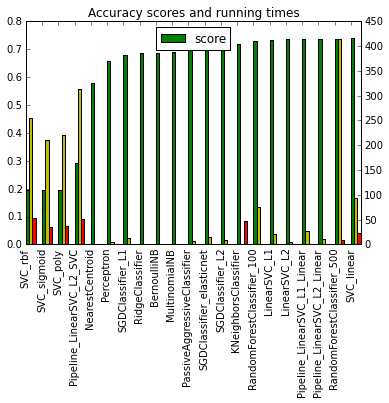

In [17]:
plt.title("Accuracy scores and running times")
width = 0.2
plt.bar(indices, score, width, label="score", color='g')
plt.legend(loc='upper center')
plt.xticks(indices, clf_names, rotation='vertical')
plt.twinx()
plt.bar(indices+width, train_time, width, label="train_time", color='y')
plt.bar(indices+(2*width), test_time, width, label="test_time", color='r')
plt.show()

In [20]:
Testing_data = pd.read_json("../input/whatscooking/test.json")
classifier = classifiers[9][1]
print "Using classifier: {}".format(classifier)
Predictions = classifier.predict(vectorizer.transform(Testing_data.ingredients.apply(lambda x: ','.join(y for y in x))))
Predicted_data = Testing_data.copy()
Predicted_data['cuisine'] = Predictions
submission = Predicted_data[['id', 'cuisine']]
import time
submission.to_csv('../output/whatscooking/whatscooking-{}.csv'.format(time.strftime("%Y%m%d--%H%M%S")), index=False)

Using classifier: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


<h3>Conclusion</h3>
I submitted the results of the "LinearSVC_L2" and "SVC_linear" classifiers as second and third submissions respectively and although SVC_linear behaved better for the in house test, it didn't beat the LinearSVC_L2 in their test sample so in some ways the SVC_linear model wasn't as generalizable.

In my next attempt, I am going to do three things. Two of those are data agnostic and the last one is data specific
<ol>
<li> Look at doing k-fold cross validation
<li> Look at doing grid search to find better parameters
<li> Look at misclassified points to see patters for where the model is going wrong
</ol>